<a href="https://colab.research.google.com/github/Vanpersact/hello-world/blob/main/1-Analise_Completa_Manifestacoes_CPTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 📦 Instalar bibliotecas necessárias
!pip install wordcloud pandas matplotlib seaborn openpyxl plotly


In [2]:
# 📚 Importação de bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import defaultdict, Counter
import os
import plotly.express as px
from datetime import datetime


In [3]:
# 📁 Carregamento da base de dados
arquivo = '/content/Manifestacoes_Ago_Set2025.xlsx'
df = pd.read_excel(arquivo)


In [4]:
# 🛠️ Ajuste de colunas caso o cabeçalho esteja na linha 2
if df.columns[0] != 'COD_MANIFESTACAO':
    df.columns = df.iloc[0]
    df = df[1:]
    df.columns.name = None


In [5]:
# 🏷️ Renomear colunas principais
df = df.rename(columns={
    "COD_MANIFESTACAO": "COD_MANIFESTACAO",
    "MOTIVO": "MOTIVO",
    "DATA_MANIF": "DATA_MANIF",
    "DIA_SEM": "DIA_SEM",
    "DATA_OCOR": "DATA_OCOR",
    "HORA_OCOR": "HORA_OCOR",
    "LOCAL_REF": "LOCAL_REF",
    "DESCRIÇÃO": "DESCRICAO",
    "CLASSIFICACAO_MANIF": "CLASSIFICACAO_MANIF",
    df.columns[-1]: "LINHA"
})


In [6]:
# ⏱️ Conversão de tipos
df["DATA_MANIF"] = pd.to_datetime(df["DATA_MANIF"], errors='coerce')
df["DATA_OCOR"] = pd.to_datetime(df["DATA_OCOR"], errors='coerce')
df["HORA_OCOR"] = pd.to_numeric(df["HORA_OCOR"], errors='coerce')


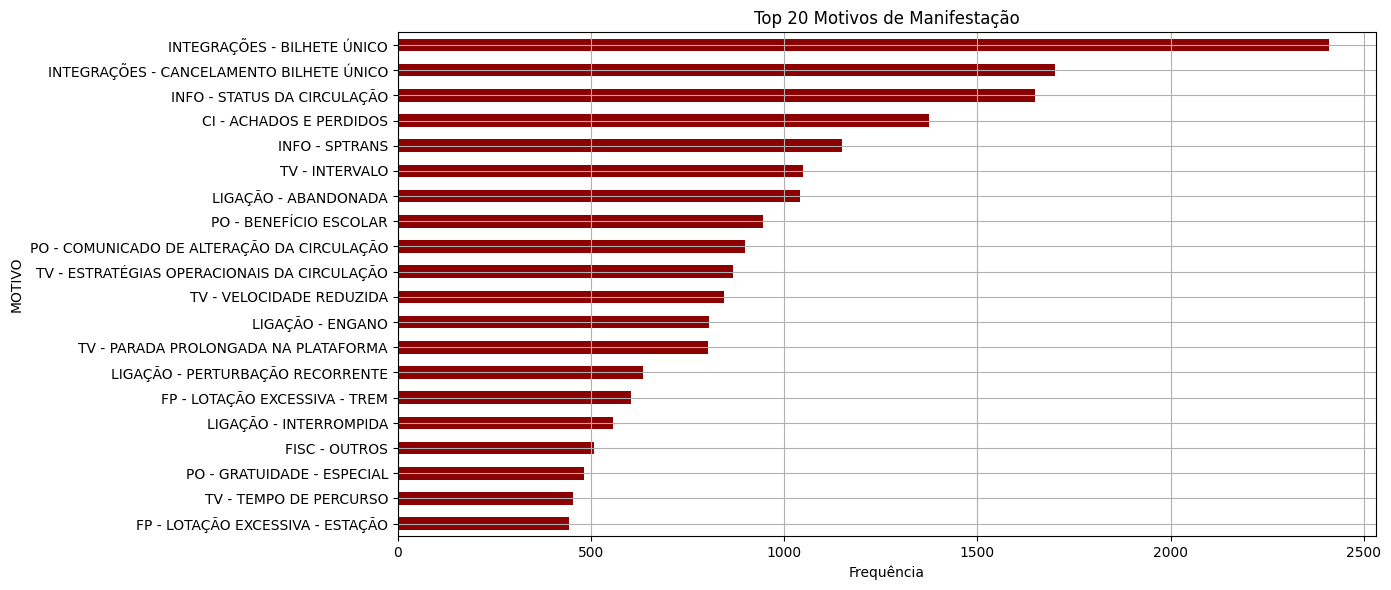

In [7]:
# 📊 Top 15 motivos de manifestação
plt.figure(figsize=(14, 6))
df["MOTIVO"].value_counts().nlargest(20).plot(kind='barh', color='darkred')
plt.title("Top 20 Motivos de Manifestação")
plt.xlabel("Frequência")
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()


/tmp/ipython-input-2279681596.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="DIA_SEM", order=dias_ordenados, palette="Reds")


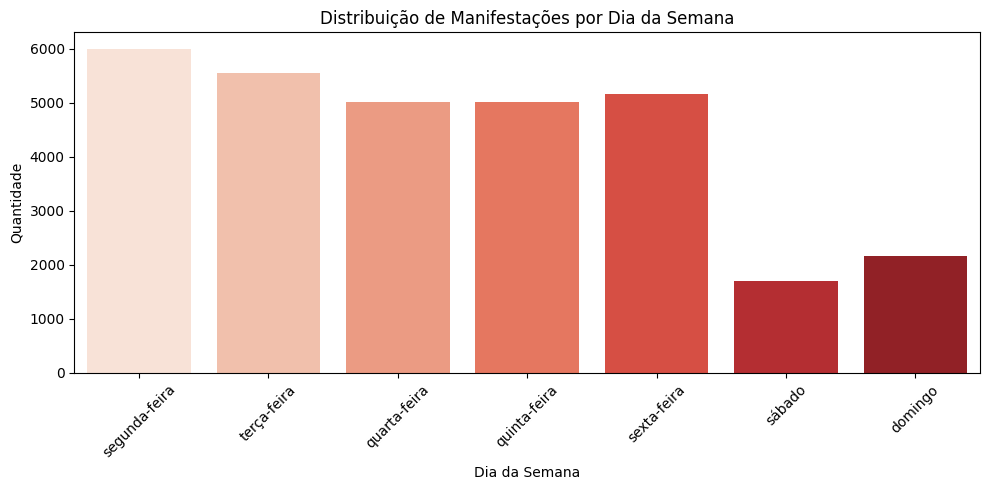

In [8]:
# 📅 Distribuição por dia da semana
dias_ordenados = ['segunda-feira', 'terça-feira', 'quarta-feira', 'quinta-feira', 'sexta-feira', 'sábado', 'domingo']
df["DIA_SEM"] = df["DIA_SEM"].str.lower()
df["DIA_SEM"] = pd.Categorical(df["DIA_SEM"], categories=dias_ordenados, ordered=True)

plt.figure(figsize=(10, 5))
sns.countplot(data=df, x="DIA_SEM", order=dias_ordenados, palette="Reds")
plt.title("Distribuição de Manifestações por Dia da Semana")
plt.ylabel("Quantidade")
plt.xlabel("Dia da Semana")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/tmp/ipython-input-3332646970.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df.pivot_table(index="HORA_OCOR", columns="DIA_SEM", aggfunc="size", fill_value=0)


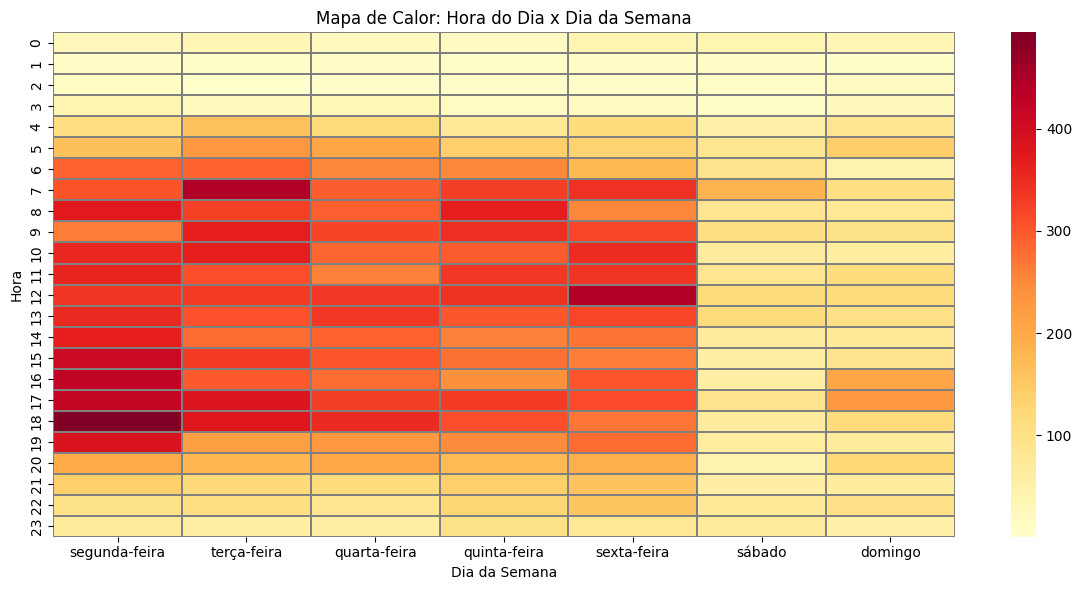

In [9]:
# 🔥 Mapa de calor por hora e dia
pivot = df.pivot_table(index="HORA_OCOR", columns="DIA_SEM", aggfunc="size", fill_value=0)
plt.figure(figsize=(12, 6))
sns.heatmap(pivot, cmap="YlOrRd", linewidths=0.3, linecolor='gray')
plt.title("Mapa de Calor: Hora do Dia x Dia da Semana")
plt.xlabel("Dia da Semana")
plt.ylabel("Hora")
plt.tight_layout()
plt.show()


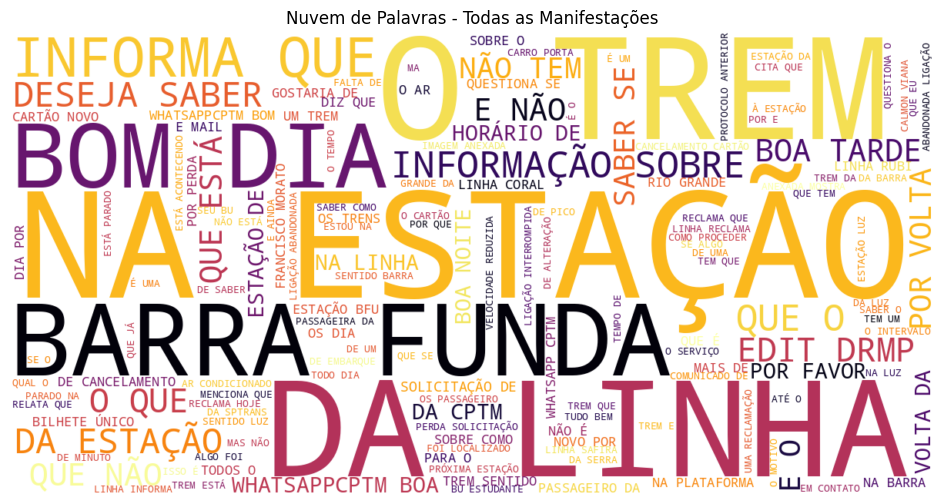

In [10]:
# ☁️ Nuvem de palavras geral (todas as manifestações)
texto = " ".join(df["DESCRICAO"].dropna().astype(str).tolist())
wordcloud = WordCloud(width=1200, height=600, background_color='white', colormap='inferno', max_words=150).generate(texto)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Nuvem de Palavras - Todas as Manifestações")
plt.show()


In [17]:
# 🎯 Foco em reclamações - apenas adjetivos (simulados)
df_reclamacoes = df[df["CLASSIFICACAO_MANIF"].str.upper() == "RECLAMAÇÃO"].copy()

adjetivos_exemplo = [
    'lento', 'sujo', 'barulhento', 'quente', 'frio', 'perigoso', 'velho', 'lotado', 'demorado',
    'inseguro', 'desconfortável', 'escuro', 'caro', 'úmido', 'horrível', 'ruim', 'péssimo',
    'fraco', 'frágil', 'instável', 'precário', 'ineficiente', 'insuficiente', 'revoltante',
    'desumano', 'inaceitável', 'desagradável', 'injusto', 'problemático', 'difícil', 'caótico',
    'quebrado', 'falho', 'irregular', 'frequente', 'inconstante', 'baixa', 'curto', 'agressivo',
    'confuso', 'degradante', 'frustrante', 'impróprio', 'inadequado', 'insuportável', 'lamentável',
    'mofado', 'obsoleto', 'pobre', 'saturado', 'sofrido', 'sufocante', 'tenso', 'triste', 'vazio',
    'interminável', 'irresponsável', 'inoperante', 'defeituoso', 'danificado', 'parado', 'pior'
]
adjetivos_set = set([a.lower() for a in adjetivos_exemplo if len(a) >= 3])

adjetivos_linha = defaultdict(list)
for linha in df_reclamacoes["LINHA"].unique():
    descricoes = df_reclamacoes[df_reclamacoes["LINHA"] == linha]["DESCRICAO"].dropna().astype(str).tolist()
    palavras = " ".join(descricoes).lower().split()
    palavras_filtradas = [p for p in palavras if p in adjetivos_set]
    adjetivos_linha[linha] = palavras_filtradas

output_folder = "/content/nuvens_adjetivos"
os.makedirs(output_folder, exist_ok=True)

for linha, lista_adjetivos in adjetivos_linha.items():
    if len(lista_adjetivos) < 5:
        continue
    texto_final = " ".join(lista_adjetivos)
    wordcloud = WordCloud(width=500, height=300, background_color='white', colormap='inferno', max_words=60).generate(texto_final)
    wordcloud.to_file(os.path.join(output_folder, f"{linha.replace(' ', '_')}.png"))


In [19]:
# 📊 Ranking completo de adjetivos por linha
ranking_completo = []
for linha, lista_adjetivos in adjetivos_linha.items():
    contagem = Counter(lista_adjetivos)
    for adjetivo, freq in contagem.items():
        ranking_completo.append({
            "Linha": linha,
            "Adjetivo": adjetivo,
            "Frequência": freq
        })

df_ranking = pd.DataFrame(ranking_completo).sort_values(by=["Linha", "Frequência"], ascending=[True, False])
df_ranking.to_excel("/content/adjetivos_por_linha.xlsx", index=False)

print("✅ Tudo pronto! Arquivos gerados:")
print("- 📁 Nuvens salvas em: /content/nuvens_adjetivos")
print("- 📊 Ranking salvo em: /content/adjetivos_por_linha.xlsx")


✅ Tudo pronto! Arquivos gerados:
- 📁 Nuvens salvas em: /content/nuvens_adjetivos
- 📊 Ranking salvo em: /content/adjetivos_por_linha.xlsx


In [ ]:
# NOVA VERSÃO PARA PEGAR MAIS PALAVRAS

In [20]:
# ==============================
# 1) Imports e helpers
# ==============================
import os, re, unicodedata
import pandas as pd
from collections import Counter
from wordcloud import WordCloud



In [21]:
# Se quiser POS-tagging (apenas adjetivos), mude para True e instale/baixe o modelo do spaCy:
USE_SPACY = False
if USE_SPACY:
    import spacy
    try:
        nlp = spacy.load("pt_core_news_sm")
    except OSError:
        # !python -m spacy download pt_core_news_sm  # descomente e rode localmente se precisar
        nlp = spacy.blank("pt")  # fallback sem POS-tagging



In [23]:
# ==============================
# 2) Parâmetros de entrada
# ==============================
COL_CLASSE = "CLASSIFICACAO_MANIF"
COL_LINHA  = "LINHA"
COL_DESC   = "DESCRICAO"

# Crie/edite sua lista manual de irrelevantes (domínio CPTM, termos muito genéricos, etc.)
irrelevantes_dom = {
    "trem","estacao","linha","cptm","metro","via","mobilidade","passageiro","passageiros",
    "plataforma","sentido","embarque","desembarque","vagao","horario","servico","viagem",
    "conexao","operacao","ferroviario","ferroviaria","trilhos","ponto","sistema","dia","noite",
    "manha","tarde","hoje","ontem","amanha","bom","boa","favor","por","gentileza","obrigado",
    "obrigada","sr","sra","etc","ex","ok","bomdia","boatarde","boanoite"
}

# Stopwords PT básicas (você pode trocar por NLTK ou outra lista)
stopwords_pt = {
    "a","à","às","ao","aos","as","o","os","um","uma","uns","umas",
    "de","do","da","dos","das","d","em","no","na","nos","nas","num","numa",
    "para","pra","pro","pela","pelas","pelo","pelos","por","com","sem","sob","sobre","entre",
    "e","ou","mas","como","que","quem","qual","quais","cujo","cujos","cuja","cujas",
    "se","já","não","sim","também","muito","muitos","muita","muitas","pouco","poucos","pouca","poucas",
    "este","esta","estes","estas","esse","essa","esses","essas","aquele","aquela","aqueles","aquelas",
    "eu","tu","ele","ela","nós","vos","eles","elas","me","te","se","lhe","lhes","nos","vos",
    "meu","minha","meus","minhas","teu","tua","teus","tuas","seu","sua","seus","suas",
    "até","após","antes","depois","durante","entre","contra","desde",
    "porque","porquê","porém","todavia","entretanto","então","logo","pois",
    "aqui","ali","lá","onde","quando","tambem"
}

# Caso você queira manter acentos para exibição mas normalizar para contagem:
def normalize_token(tok: str) -> str:
    # remove acento e deixa minúsculo
    t = unicodedata.normalize("NFKD", tok).encode("ascii", "ignore").decode("ascii")
    return t.lower()

TOKEN_MIN_LEN = 2  # descarta tokens muito curtos (ex: 'de', 'a', etc.)
KEEP_ACCENTS_FOR_DISPLAY = True  # mantém a forma original em relatórios, mas conta na forma normalizada



In [24]:
# ==============================
# 3) Seleção: somente RECLAMAÇÃO
# ==============================
df_reclamacoes = df[df[COL_CLASSE].str.upper() == "RECLAMAÇÃO"].copy()
df_reclamacoes = df_reclamacoes.dropna(subset=[COL_DESC])

# ==============================
# 4) Tokenização e limpeza
# ==============================
url_pat   = re.compile(r"https?://\S+|www\.\S+")
email_pat = re.compile(r"\S+@\S+")
# mantém apenas letras (inclui acentuadas) e hífen interno. Troca o resto por espaço.
letters_pat = re.compile(r"[^A-Za-zÀ-ÖØ-öø-ÿ\-]+")

def tokenize_pt(texto: str):
    # remove URLs/emails
    t = url_pat.sub(" ", str(texto))
    t = email_pat.sub(" ", t)
    # padroniza apóstrofos/hífens
    t = t.replace("’", "'").replace("–", "-").replace("—", "-")
    # remove tudo que não for letra/hífen
    t = letters_pat.sub(" ", t)
    # quebra
    raw_tokens = [w.strip("-") for w in t.split() if w.strip("-")]
    return raw_tokens

# Explode por manifestação (id opcional, se existir)
id_col = "ID" if "ID" in df_reclamacoes.columns else None
rows = []
for idx, row in df_reclamacoes.iterrows():
    linha = str(row.get(COL_LINHA, "SEM_LINHA"))
    desc  = str(row[COL_DESC])
    toks  = tokenize_pt(desc)

    for w in toks:
        w_norm = normalize_token(w)
        if len(w_norm) < TOKEN_MIN_LEN:
            continue
        # stoplists (normalizadas)
        if w_norm in {normalize_token(x) for x in stopwords_pt}:
            continue
        if w_norm in {normalize_token(x) for x in irrelevantes_dom}:
            continue
        rows.append({
            "linha": linha,
            "token": w if KEEP_ACCENTS_FOR_DISPLAY else w_norm,
            "token_norm": w_norm,
            "manifestacao_id": row[id_col] if id_col else idx
        })

tokens_df = pd.DataFrame(rows)



In [ ]:
# ==============================
# 5) (Opcional) filtrar só ADJETIVOS com spaCy
# ==============================
if USE_SPACY and not nlp.pipe_names:
    nlp.add_pipe("tagger")  # fallback mínimo

if USE_SPACY and len(tokens_df) > 0:
    # Para manter performance, processa em lote por manifestação + reconstrói adjetivos
    # Observação: como perdemos contexto por token, aqui simplificamos e checamos POS no texto completo.
    # Alternativa robusta: reprocessar DESCRICAO e marcar as palavras ADJ.
    adjetivos_norm = set()
    for _, r in df_reclamacoes.iterrows():
        doc = nlp(str(r[COL_DESC]))
        for t in doc:
            if t.pos_ == "ADJ":
                adjetivos_norm.add(normalize_token(t.text))
    tokens_df = tokens_df[tokens_df["token_norm"].isin(adjetivos_norm)].copy()



In [25]:
# ==============================
# 6) Tabela mestra (todas as palavras)
# ==============================
# Frequência total
freq_total = tokens_df.groupby("token", as_index=False).agg(
    freq=("token", "count"),
    docs=("manifestacao_id", pd.Series.nunique)
).sort_values("freq", ascending=False)

# Frequência por LINHA
freq_linha = tokens_df.groupby(["linha", "token"], as_index=False).agg(
    freq=("token", "count"),
    docs=("manifestacao_id", pd.Series.nunique)
).sort_values(["linha","freq"], ascending=[True, False])

# (Opcional) pivot por LINHA para visão rápida
pivot_linha = freq_linha.pivot_table(index="token", columns="linha", values="freq", fill_value=0)
pivot_linha = pivot_linha.sort_values(by=pivot_linha.columns.tolist(), ascending=False)



In [27]:
# ==============================
# 7) Exportar para Excel (você edita e me devolve a lista "aprovada")
# ==============================

!pip install xlsxwriter

saida_excel = "palavras_reclamacoes.xlsx"
with pd.ExcelWriter(saida_excel, engine="xlsxwriter") as xw:
    freq_total.to_excel(xw, index=False, sheet_name="todas_palavras")
    freq_linha.to_excel(xw, index=False, sheet_name="por_linha")
    pivot_linha.reset_index().to_excel(xw, index=False, sheet_name="pivot_linha")
print(f"Arquivo gerado: {saida_excel}")



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.3/175.3 kB 4.7 MB/s eta 0:00:00
Arquivo gerado: palavras_reclamacoes.xlsx


In [ ]:
# ==============================
# 8) (Depois) Você me devolve uma lista aprovada
#    Ex.: um CSV com uma coluna 'token' contendo as palavras que deseja manter
# ==============================
# Exemplo de leitura (descomente quando tiver o arquivo):
# aprovadas = pd.read_csv("palavras_aprovadas.csv")  # coluna 'token'
# aprovadas["token_norm"] = aprovadas["token"].map(normalize_token)
# tokens_filtrado = tokens_df[tokens_df["token_norm"].isin(set(aprovadas["token_norm"]))].copy()

# Para fins de demonstração, vou fingir que aprovamos as 500 mais frequentes:
topN = 500
tokens_filtrado = tokens_df.merge(freq_total.head(topN)[["token"]], on="token", how="inner")



In [ ]:
# ==============================
# 9) Geração da nuvem de palavras (por LINHA e geral)
# ==============================
output_folder = "nuvens_palavras"
os.makedirs(output_folder, exist_ok=True)

def gerar_wordcloud(texto, nome_arquivo, width=1200, height=700, max_words=200):
    if not texto.strip():
        return
    wc = WordCloud(
        width=width, height=height,
        background_color="white",
        max_words=max_words
        # sem colormap fixo p/ manter estilo neutro; ajuste se quiser
    ).generate(texto)
    wc.to_file(os.path.join(output_folder, nome_arquivo))

# Por linha
for linha, sub in tokens_filtrado.groupby("linha"):
    palavras = " ".join(sub["token"].tolist())
    if len(palavras.split()) >= 5:
        gerar_wordcloud(palavras, f"linha_{str(linha).replace(' ','_')}.png")

# Geral
geral_texto = " ".join(tokens_filtrado["token"].tolist())
gerar_wordcloud(geral_texto, "geral.png")

print(f"Imagens salvas em: {output_folder}")

In [ ]:
#novo código para as nuvens de palavras com padronização/normalização

In [30]:
# === NOVO BLOCO: ler a matriz enriquecida ===
# Pode ser o mesmo arquivo que você exportou, desde que agora tenha as colunas novas
ARQ_MATRIZ = "Palavras_reclamacoes_padronizado.xlsx"  # ajuste se seu arquivo tiver outro nome
ABA_MATRIZ = "Aprovadas"             # ajuste se estiver em outra aba

matriz = pd.read_excel(ARQ_MATRIZ, sheet_name=ABA_MATRIZ)

# Normaliza nomes de colunas
matriz.columns = [c.strip().lower() for c in matriz.columns]

# Garante existência das colunas esperadas
esperadas = {"token", "padronizacao", "aprovadas"}
faltando = esperadas - set(matriz.columns)
if faltando:
    raise ValueError(f"Faltam colunas na planilha: {faltando}")

# Limpezas de base
matriz["token"] = matriz["token"].astype(str).str.strip()
matriz["padronizacao"] = matriz["padronizacao"].astype(str).fillna("").str.strip()
matriz["aprovadas"] = matriz["aprovadas"].astype(str).fillna("").str.strip().str.upper()

# Sinal binário de aprovadas (aceita X, SIM, S, 1, TRUE)
matriz["is_aprovada"] = matriz["aprovadas"].isin(["X","SIM","S","1","TRUE","T"])

# Para casar com tokens_df com robustez, criamos a chave normalizada
matriz["token_norm"] = matriz["token"].map(normalize_token)

# Fallback de padronização: se vazio, usar token normalizado
matriz["padronizacao_norm"] = matriz["padronizacao"]
matriz.loc[matriz["padronizacao_norm"].eq(""), "padronizacao_norm"] = matriz.loc[
    matriz["padronizacao_norm"].eq(""), "token_norm"
]

In [31]:
# === SUBSTITUIR BLOCO DE FILTRO/SELEÇÃO ===
# Junta tokens detectados (tokens_df) com sua matriz (por token_norm)
tokens_join = tokens_df.merge(
    matriz[["token_norm","padronizacao","padronizacao_norm","is_aprovada"]],
    on="token_norm", how="left"
)

# Se não tiver padronizacao definida, usa o próprio token (display)
tokens_join["padronizacao_final"] = tokens_join["padronizacao"]
tokens_join.loc[
    tokens_join["padronizacao_final"].isna() | (tokens_join["padronizacao_final"].astype(str).str.len()==0),
    "padronizacao_final"
] = tokens_join["token"]

# Mantém apenas as aprovadas
tokens_aprov = tokens_join[tokens_join["is_aprovada"].fillna(False)].copy()

# WordCloud trata espaço como separador; para manter termos compostos como uma “palavra”, trocamos por underscore
import re
tokens_aprov["wc_token"] = tokens_aprov["padronizacao_final"].astype(str).apply(lambda s: re.sub(r"\s+","_",s))

In [32]:
# === NOVO: dicionários de frequências para a nuvem ===
# Geral
freq_geral = tokens_aprov["wc_token"].value_counts().to_dict()

# Por linha
freq_por_linha = (
    tokens_aprov.groupby(["linha","wc_token"])
    .size()
    .reset_index(name="freq")
)

# (Opcional) salvar um Excel com as frequências padronizadas aprovadas, para auditoria
with pd.ExcelWriter("freq_aprovadas.xlsx", engine="openpyxl") as xw:
    pd.Series(freq_geral, name="freq").rename_axis("padronizacao").reset_index() \
        .to_excel(xw, index=False, sheet_name="geral")
    freq_por_linha.to_excel(xw, index=False, sheet_name="por_linha")

In [39]:
# === SUBSTITUIR A PARTE DAS NUVENS (maiores=vermelho, menores=preto) ===
import os, re
from wordcloud import WordCloud
import numpy as np
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib import cm

output_folder = "nuvens_palavras"
os.makedirs(output_folder, exist_ok=True)

# Paleta (baixo→alto, já na ordem fria→quente — o PRETO vai por regra abaixo, via threshold)
# roxo escuro → roxo claro → cinza → amarelo → laranja → vermelho claro → vermelho real
colors = [
    (0.26, 0.00, 0.40),  # roxo escuro
    (0.60, 0.40, 0.80),  # roxo claro
    (0.60, 0.60, 0.60),  # cinza
    (1.00, 0.90, 0.00),  # amarelo
    (1.00, 0.60, 0.00),  # laranja
    (1.00, 0.40, 0.40),  # vermelho claro
    (0.80, 0.00, 0.00),  # vermelho real
]
cmap = LinearSegmentedColormap.from_list("cool_to_hot", colors, N=256)

# % mais baixo que irá em PRETO (ajuste se quiser)
PCT_PRETO = 0.25  # 25% mais baixas ficam pretas

def _wc_term(s: str) -> str:
    return re.sub(r"\s+", "_", str(s).strip())

def _make_color_func(freq_dict, pct_preto=PCT_PRETO):
    vals = np.array(list(freq_dict.values()), dtype=float)
    vmin, vmax = float(vals.min()), float(vals.max())
    if vmin == vmax:  # evita faixa nula
        vmin, vmax = vmin - 1.0, vmax + 1.0

    def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
        f = float(freq_dict.get(word, vmin))
        # normaliza para [0,1]
        x = (f - vmin) / (vmax - vmin)
        # parte preta (palavras menores)
        if x <= pct_preto:
            return "rgb(0,0,0)"
        # remapeia o restante para [0,1] e aplica gradiente até vermelho
        x2 = (x - pct_preto) / (1.0 - pct_preto)
        r, g, b, _ = cm.ScalarMappable(norm=Normalize(0, 1), cmap=cmap).to_rgba(x2)
        return f"rgb({int(r*255)},{int(g*255)},{int(b*255)})"

    return color_func

def gerar_wordcloud_freq(freq_dict, nome_arquivo, width=1200, height=700, max_words=200):
    if not freq_dict:
        return
    wc = WordCloud(
        width=width, height=height, background_color="white",
        max_words=max_words, collocations=False
    ).generate_from_frequencies(freq_dict)
    wc = wc.recolor(color_func=_make_color_func(freq_dict))
    wc.to_file(os.path.join(output_folder, nome_arquivo))

# ---------- Nuvem geral ----------
# freq_geral: {padronizacao: freq}
freq_geral_wc = { _wc_term(k): v for k, v in freq_geral.items()
                  if isinstance(k, str) and k.strip() and k.lower() != "nan" }
gerar_wordcloud_freq(freq_geral_wc, "geral.png")

# ---------- Nuvens por LINHA ----------
# freq_por_linha com colunas ["linha","padronizacao","freq"]
for linha, sub in freq_por_linha.groupby("linha"):
    sub = sub.dropna(subset=["padronizacao"])
    sub = sub[sub["padronizacao"].astype(str).str.strip().ne("") &
              sub["padronizacao"].astype(str).str.lower().ne("nan")]
    labels = sub["padronizacao"].astype(str).map(_wc_term)
    freq_dict = dict(zip(labels, sub["freq"]))
    if sum(freq_dict.values()) < 5:
        continue
    gerar_wordcloud_freq(freq_dict, f"linha_{str(linha).replace(' ','_')}.png")